<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter10/RNN.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

values = [         
  112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
  141., 135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
  172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193., 181., 183., 218.,
  230., 242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264., 272.,
  237., 211., 180., 201., 204., 188., 235., 227., 234., 264., 302., 293., 259., 229.,
  203., 229., 242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237., 278.,
  284., 277., 317., 313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301.,
  356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318., 362., 348.,
  363., 435., 491., 505., 404., 359., 310., 337., 360., 342., 406., 396., 420., 472.,
  548., 559., 463., 407., 362., 405., 417., 391., 419., 461., 472., 535., 622., 606.,
  508., 461., 390., 432.,
 ]
idx = pd.date_range("1949-01-01", periods=len(values), freq="M")
passengers = pd.Series(values, index=idx, name="passengers").to_frame()

/tmp/ipykernel_2496/3813778322.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range("1949-01-01", periods=len(values), freq="M")


In [3]:
passengers

,passengers
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0
...,...
1960-08-31,606.0
1960-09-30,508.0
1960-10-31,461.0
1960-11-30,390.0


In [4]:
LOOKBACK = 10

def wrap_data(df, lookback):
  dataset = []
  for index in range(lookback, len(df)+1):
    features = {
        f"col_{i}": float(val) for i, val in enumerate(
          df.iloc[index-lookback:index].values
        )
    }
    row = pd.DataFrame.from_dict([features])
    row.index = [df.index[index-1]]
    dataset.append(row)
  return pd.concat(dataset, axis=0)

dataset = wrap_data(passengers, lookback=LOOKBACK)
dataset = dataset.join(passengers.shift(-1))

/tmp/ipykernel_2496/3288517200.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"col_{i}": float(val) for i, val in enumerate(


In [5]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

def create_model(passengers):
    input_layer = Input(shape=(LOOKBACK, 1))
    recurrent = Bidirectional(LSTM(20, activation="tanh"))(input_layer)
    output_layer = Dense(1)(recurrent)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='mse', optimizer=keras.optimizers.Adagrad(),
        metrics=[
            keras.metrics.RootMeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
    ])
    return model

model = create_model(passengers)

2025-05-30 12:21:43.738555: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 12:21:43.746268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748600503.755112    2496 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748600503.758248    2496 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748600503.766180    2496 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns="passengers"),
    dataset["passengers"],
    shuffle=False
)

In [7]:
model.fit(X_train, y_train, epochs=1000, callbacks=[callback])

Epoch 1/1000


E0000 00:00:1748600508.446583   15147 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-05-30 12:21:48.447161: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at cudnn_rnn_ops.cc:1769 : INVALID_ARGUMENT: Dnn is not supported
2025-05-30 12:21:48.447197: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Dnn is not supported
	 [[{{function_node __inference_one_step_on_data_1936}}{{node functional_1/bidirectional_1/forward_lstm_1/CudnnRNNV3}}]]
E0000 00:00:1748600508.448061   15147 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs 

InvalidArgumentError: Graph execution error:

Detected at node functional_1/bidirectional_1/forward_lstm_1/CudnnRNNV3 defined at (most recent call last):
  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/runpy.py", line 198, in _run_module_as_main

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/runpy.py", line 88, in _run_code

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/root/miniconda3/envs/TimeSeries_clone/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_2496/2855117288.py", line 1, in <module>

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/root/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/root/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/root/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/root/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 183, in call

  File "/root/.local/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/root/.local/lib/python3.12/site-packages/keras/src/models/functional.py", line 643, in call

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py", line 218, in call

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/root/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/root/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 584, in call

  File "/root/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py", line 408, in call

  File "/root/.local/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 551, in inner_loop

  File "/root/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/root/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Dnn is not supported
	 [[{{node functional_1/bidirectional_1/forward_lstm_1/CudnnRNNV3}}]] [Op:__inference_multi_step_on_iterator_1990]

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def show_result(y_test, predicted):
  plt.figure(figsize=(16, 6))
  plt.plot(y_test.index, predicted, 'o-', label="predicted")
  plt.plot(y_test.index, y_test, '.-', label="actual")

  plt.ylabel("Passengers")
  plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


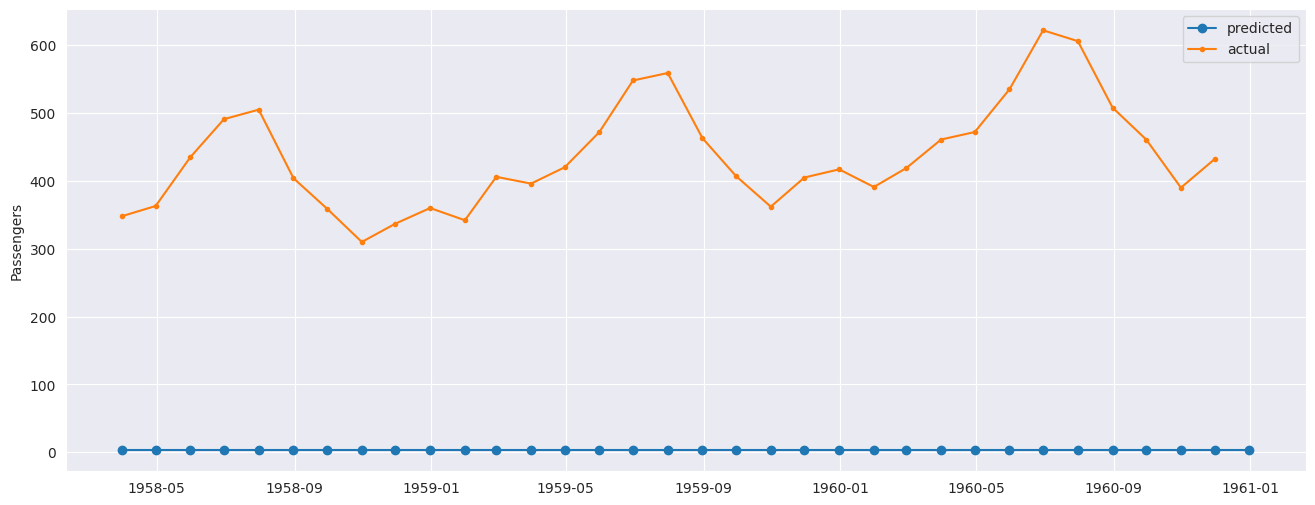

In [8]:
predicted = model.predict(X_test)
show_result(y_test, predicted)